# Data preparation

In [2]:
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
from src.ingestion.download_samples import download_samples
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import aiohttp
import asyncio
import pandas as pd
import itertools
import spacy
import scispacy
from scispacy.linking import EntityLinker
from src.model.geo_dataset import GEODataset
from src.model.geo_sample import GEOSample
from typing import Tuple, List, Dict
from dateutil.parser import parse as parse_date
import datetime

{"asctime": "2025-06-06 14:54:41,307", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: INT"}
{"asctime": "2025-06-06 14:54:41,308", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: FLOAT"}
{"asctime": "2025-06-06 14:54:41,308", "levelname": "INFO", "message": "Registering at the factory, space: bit_hamming distance type: INT"}
{"asctime": "2025-06-06 14:54:41,309", "levelname": "INFO", "message": "Registering at the factory, space: bit_jaccard distance type: FLOAT"}
{"asctime": "2025-06-06 14:54:41,309", "levelname": "INFO", "message": "Registering at the factory, space: leven distance type: INT"}
{"asctime": "2025-06-06 14:54:41,309", "levelname": "INFO", "message": "Registering at the factory, space: normleven distance type: FLOAT"}
{"asctime": "2025-06-06 14:54:41,309", "levelname": "INFO", "message": "Registering at the factory, space: kldivfast distance type: FLOAT"}
{"asctime": "2025-06-06 14:54:41,3

In [3]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/src/ingestion/download_related_paper_datasets.py:15: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(paper_export["df"])


197


# Dataset metadata

## Experiment types

In [4]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Other', 'Other', 'Other', 'Expression profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Methylation profiling by genome tiling array', 'Other']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


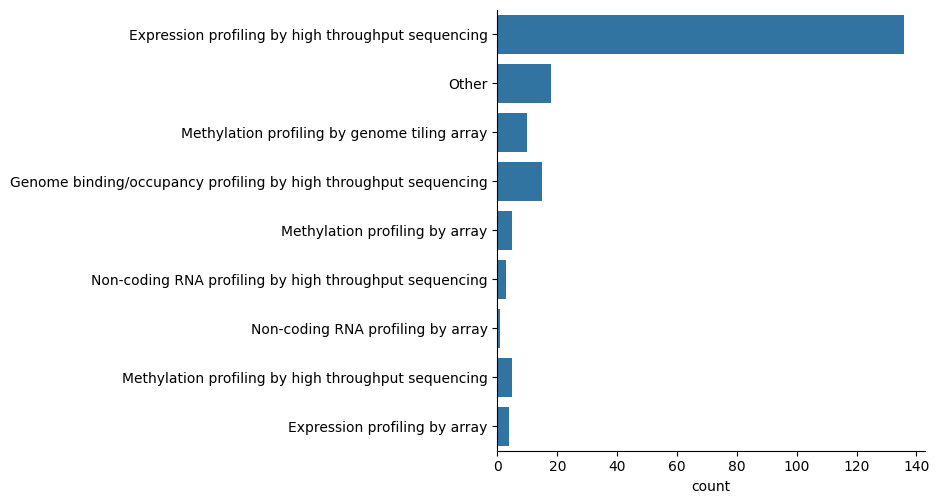

In [5]:
sns.catplot(experiment_types, kind="count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

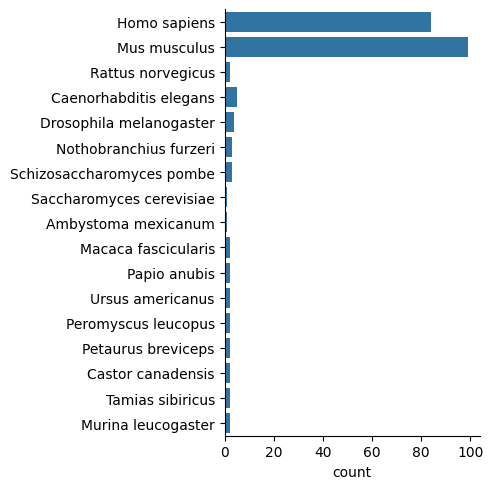

In [6]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
sns.catplot(organisms, kind="count")

Most datasets are collected from either mice or people.

In [7]:
## Title wordcolud

In [8]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

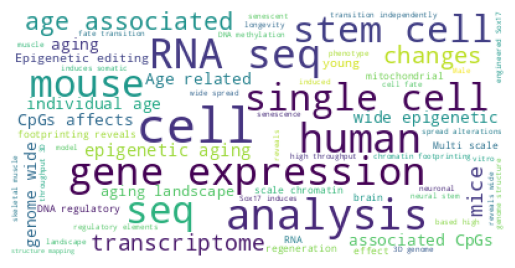

In [9]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

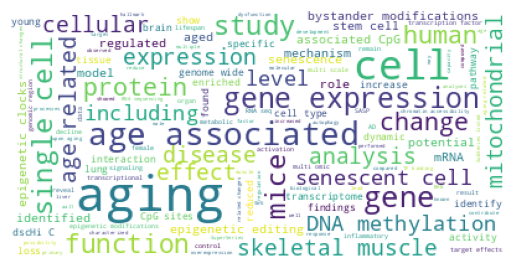

In [10]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

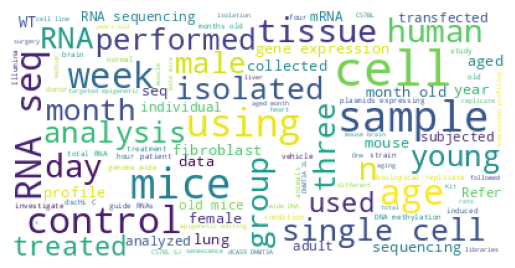

In [11]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

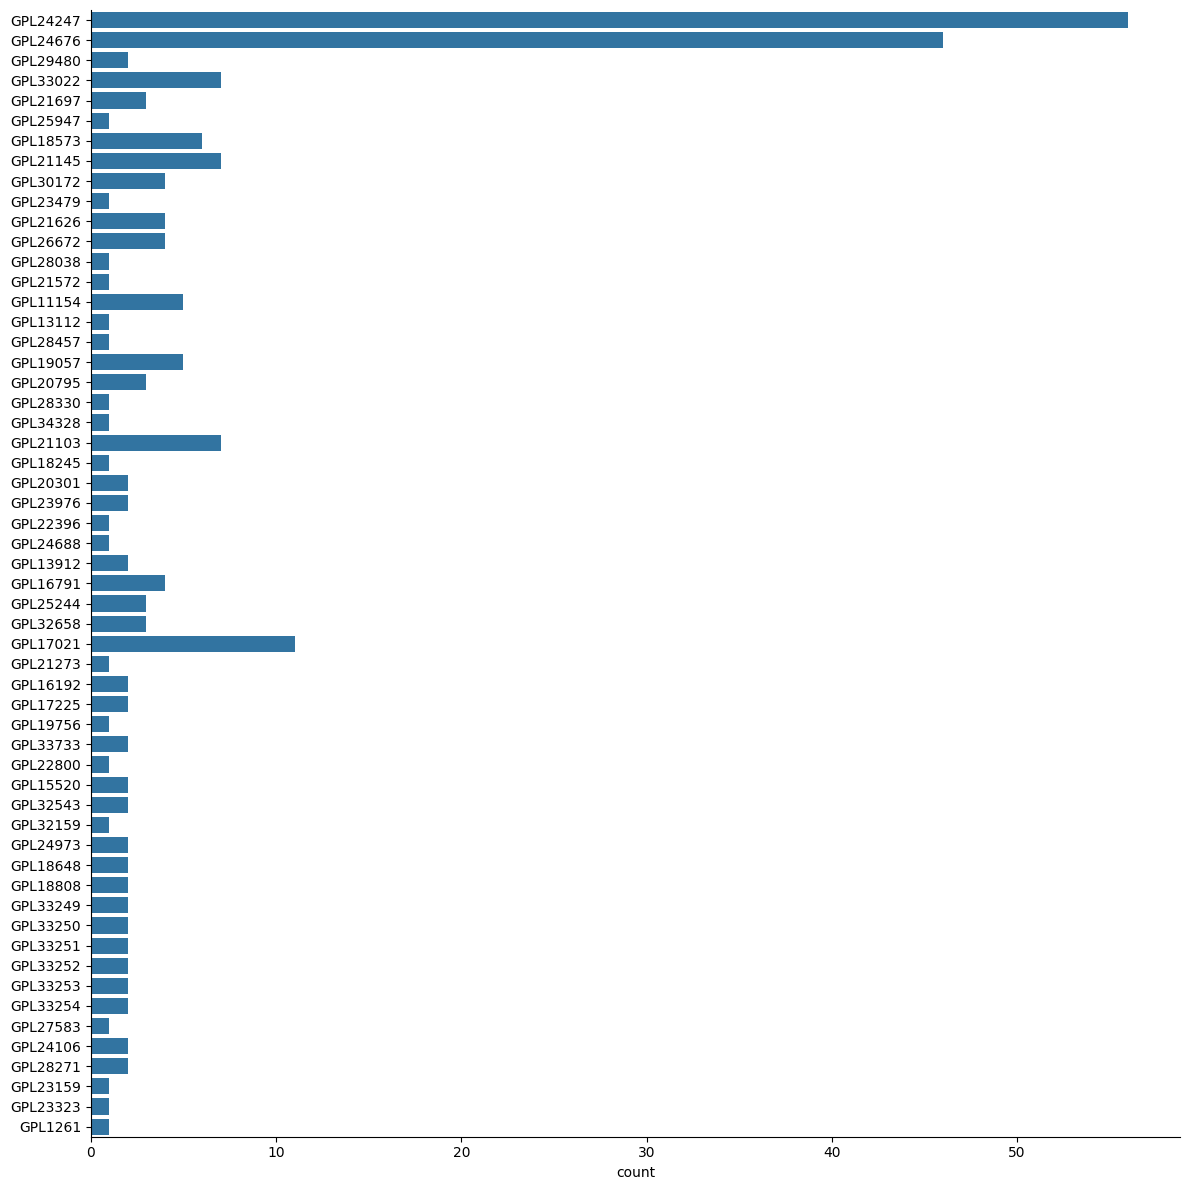

In [12]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=12)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

## Publication date

{"asctime": "2025-06-06 14:57:05,207", "levelname": "INFO", "message": "Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting."}
{"asctime": "2025-06-06 14:57:05,211", "levelname": "INFO", "message": "Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting."}


<Axes: title={'center': 'Number of datasets published each year'}, xlabel='count'>

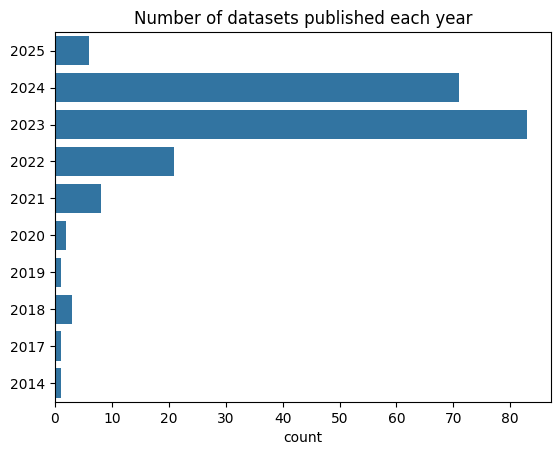

In [34]:
plt.title("Number of datasets published each year")
sns.countplot([str(dataset.publication_date.year) for dataset in datasets])

# Clustering

In [14]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = 9999999
best_n_clusters = None

for n_clusters in range(5, 25):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score < best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

{"asctime": "2025-06-06 14:54:46,202", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-06 14:54:46,209", "levelname": "INFO", "message": "Silhouette score: 0.21746171873017064"}
{"asctime": "2025-06-06 14:54:46,209", "levelname": "INFO", "message": "Clustering time: 0.00s"}
{"asctime": "2025-06-06 14:54:46,740", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-06 14:54:46,753", "levelname": "INFO", "message": "Silhouette score: 0.2511566579304501"}
{"asctime": "2025-06-06 14:54:46,754", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-06 14:54:47,289", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-06 14:54:47,302", "levelname": "INFO", "message": "Silhouette score: 0.2862717862161221"}
{"asctime": "2025-06-06 14:54:47,305", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-06 

Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [15]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [16]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

,Color,Datasets,Topics
#,,,
1,#1f77b4,82,"single, changes, brain, dna, mouse, age, chromatin, methylation, gene, reprogramming"
2,#ff7f0e,66,"old, mice, mitochondrial, related, human, analysis, seq, tissue, young, aged"
3,#2ca02c,23,"senescent, senescence, sasp, stress, acss2, atm, induced, er, promotes, phenotype"
4,#d62728,14,"muscle, skeletal, dnmt3a, sarcopenia, hypercapnia, mice, biopsies, autophagy, tg, elderly"
5,#9467bd,12,"epigenetic, editing, cpgs, modifications, wide, targeted, associated, age, sites, bystander"


# Sample metadata

In [17]:
# Download samples
samples = set() # We are using a set because some samples can occur twice. For example, a sample appears twice when it is in a subseries and superseries
async with aiohttp.ClientSession() as session:
    for series in datasets:
        series.samples = await download_samples(series, session)
        samples.update(series.samples)

accessions = [sample.accession for sample in samples]
assert len(set(accessions)) == len(samples)

## Number of samples

In [18]:
len(samples)

3946

## Most common sample types

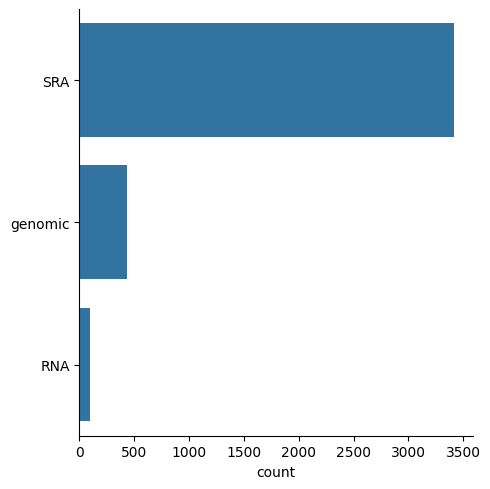

In [19]:
sample_types = [sample.sample_type for sample in samples]
sns.catplot(sample_types, kind="count")

## Most common characteristics keys

Text(0.5, 1.0, 'Most common characterisitics keys')

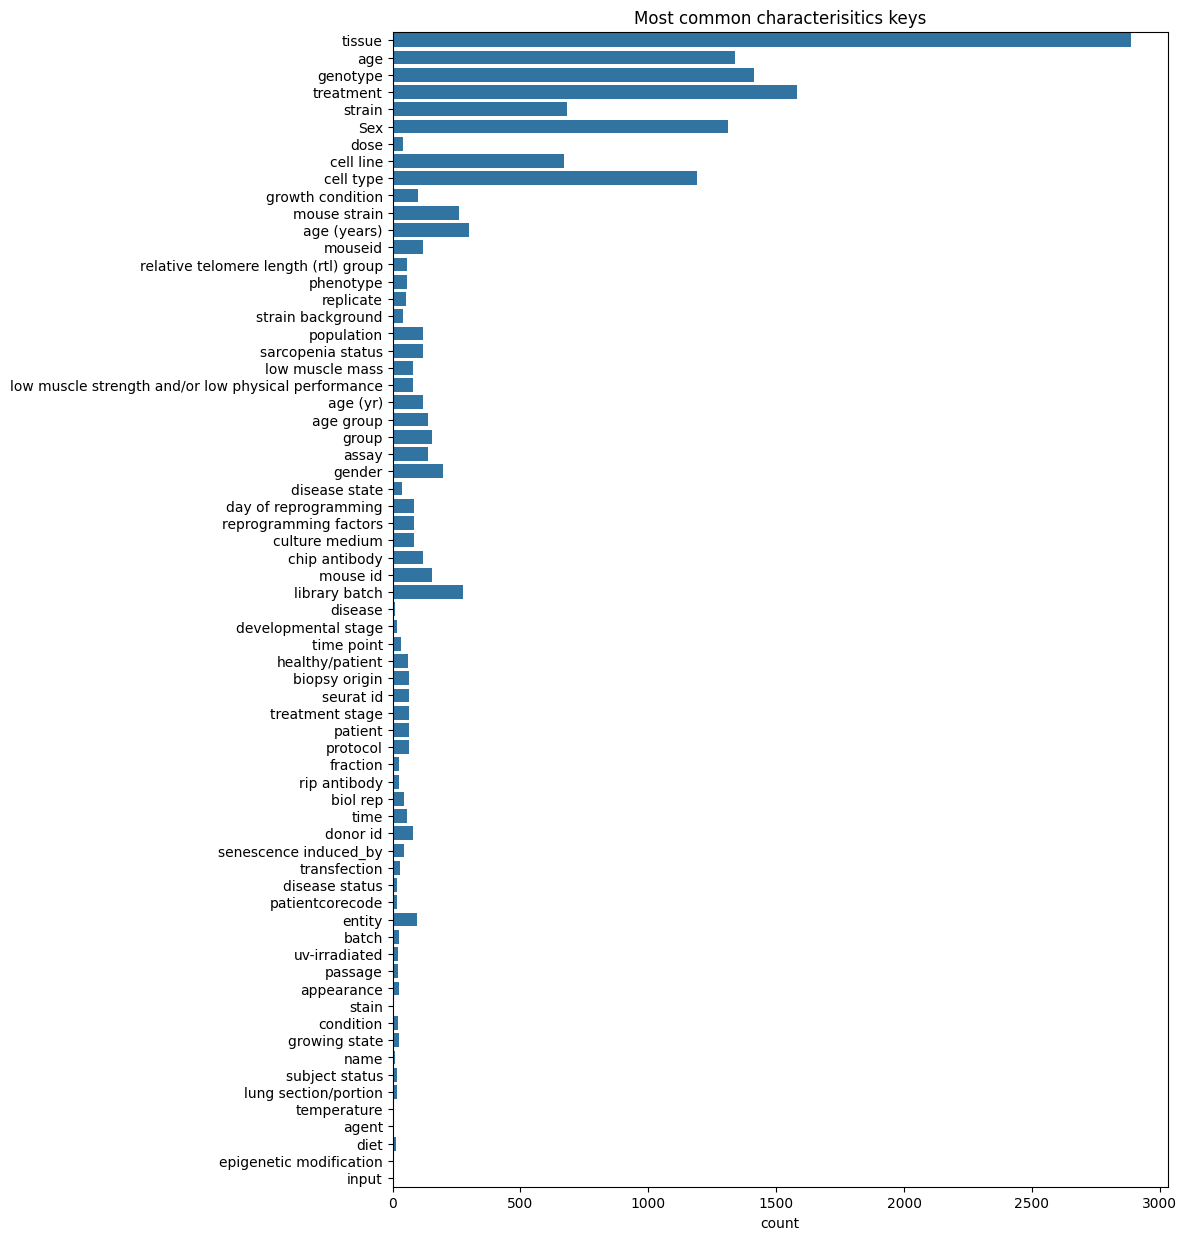

In [20]:
characteristics_keys = [key for sample in samples for key in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 15))
sns.countplot(characteristics_keys, ax=ax)
ax.set_title("Most common characterisitics keys")

In [21]:
pd.Series(characteristics_keys).value_counts().head(10)

tissue           2886
treatment        1580
genotype         1413
age              1339
Sex              1313
cell type        1192
strain            683
cell line         672
age (years)       297
library batch     275
Name: count, dtype: int64

## Number of samples that have data tables

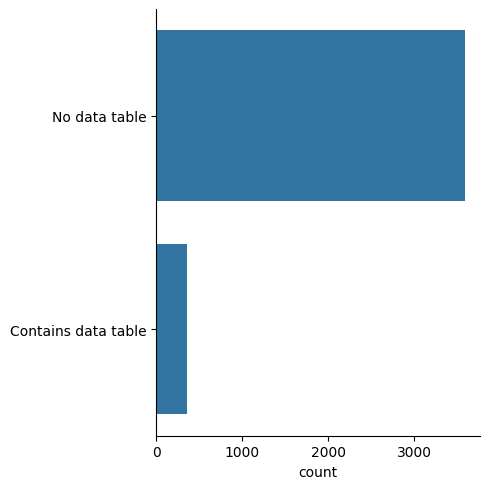

In [22]:
contains_data_table = ["Contains data table" if sample.metadata["data_row_count"][0] != "0" else "No data table" for sample in samples]
sns.catplot(contains_data_table, kind="count")

It seems that relatively few samples have data tables. Therefore, most data is raw sequencing data. 

## Most common tissues

Text(0.5, 1.0, 'Number of samples per tissue')

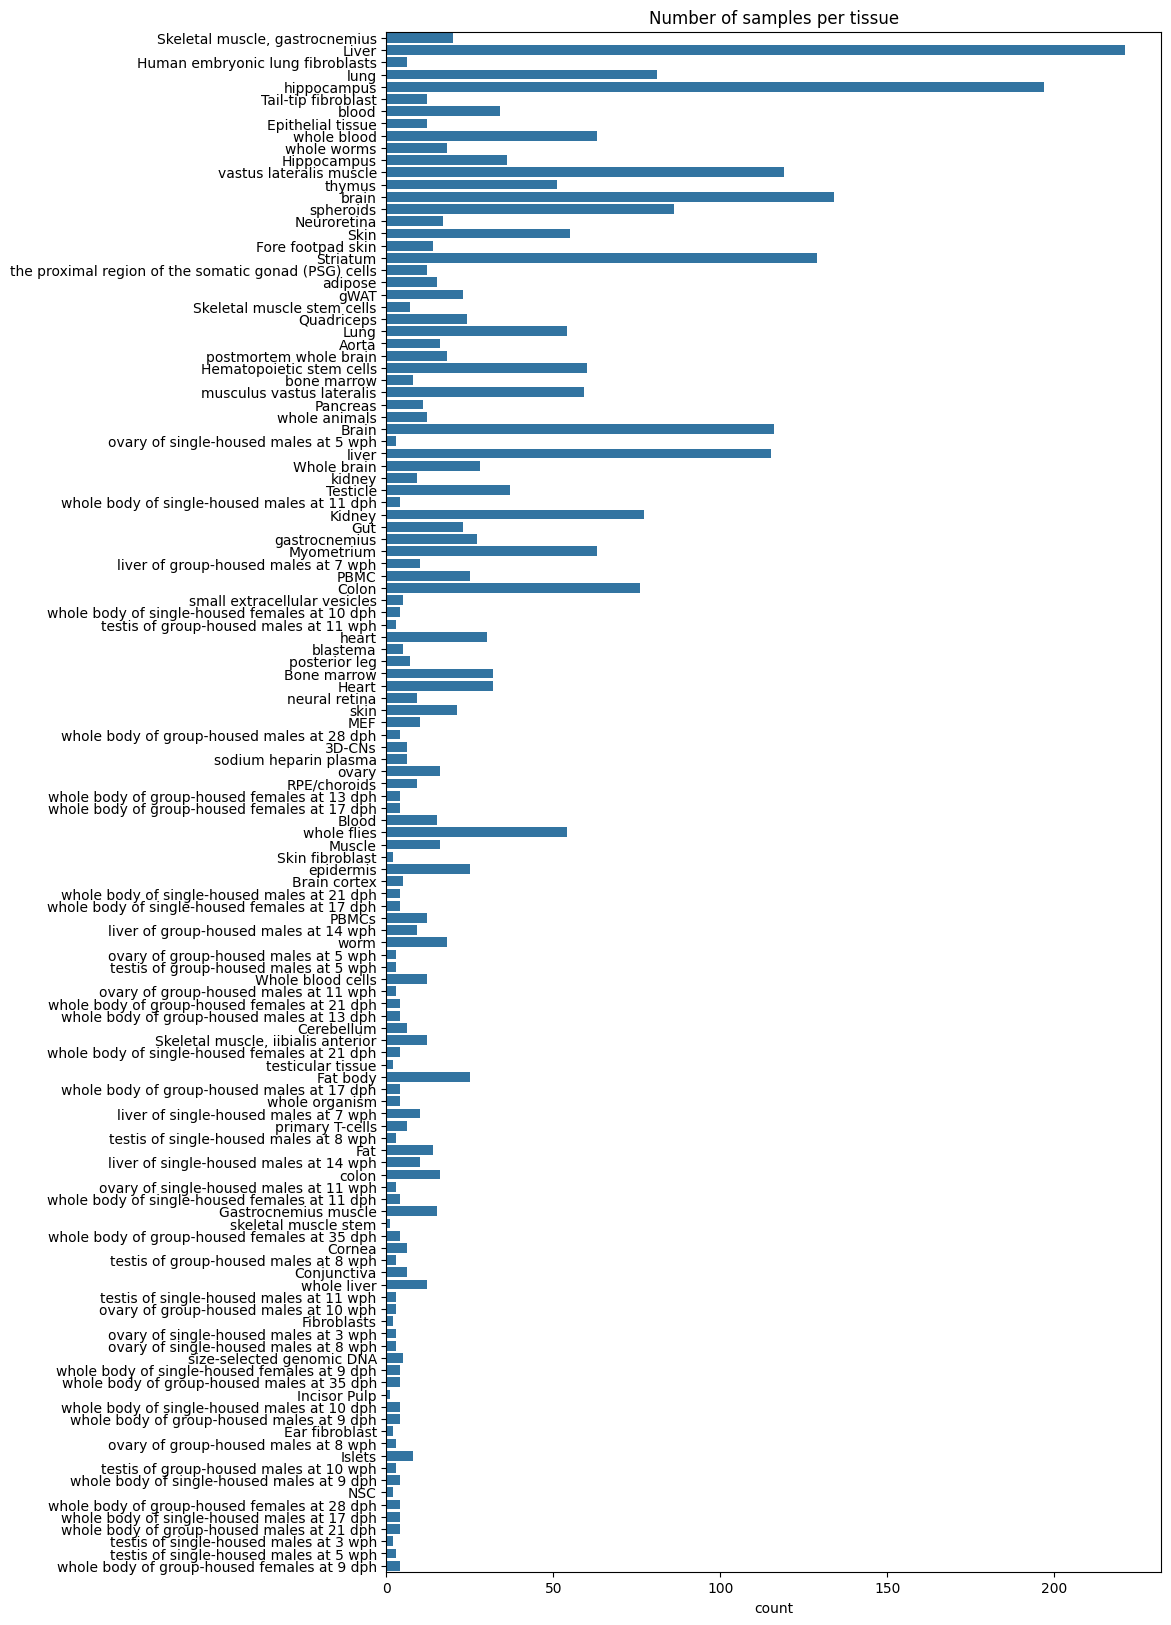

In [23]:
tissues = [sample.characteristics["tissue"] for sample in samples if "tissue" in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues, ax=ax)
ax.set_title("Number of samples per tissue")

There are different names for the same tissue depending on how specific the author wanted to be. Let's try grouping the synonyms together.

The following groupings were obtained using LLama.3.3-70B with the following prompt:

Here is a list of tissue names as extracted from Gene Expression Omnibus sample records. There are different names for the same kind of tissue in the list. Group the synonymous tissue names and give the group a meaningful name. If there are no synonyms for a tissue type create a new group for each such tissue ("<tissue>": ["<tissue>"]). Do not create a category name like "Other". Make sure every item in the list is covered.

Output a JSON where the keys are the group names and the values are the synonyms in that group.

List of tissue names: \<python list of tissue names\>

In [24]:
synonym_groups = \
{
    "Fibroblasts": [
        "Dermal Fibroblast",
        "Fibroblast",
        "Fibroblasts",
        "Human Fibroblast",
        "Human embryonic lung fibroblasts",
        "Mouse embryonic fibroblast",
        "Mouse embryonic fibroblasts",
        "old fibroblasts",
        "Primary lung fibroblasts"
    ],
    "Neural Stem Cells": [
        "fetal primary NSC",
        "miNSC",
        "NSC",
        "old NSC",
        "old miNSC",
        "Primary neural stem cells"
    ],
    "Lung Cells": [
        "Lung cells",
        "mix cell types from lung"
    ],
    "Hepatocytes": [
        "hepatoma cell",
        "Hepatocyte",
        "hepatocellular carcinoma",
        "liver"
    ],
    "Mesenchymal Stromal Cells": [
        "Mesenchymal stromal cell",
        "Mesenchymal stromal cells",
        "human Mesenchymal stem cells",
        "mesenchymal stem cells"
    ],
    "Blood Cells": [
        "Bone marrow cells",
        "Bone marrow mononuclear cells",
        "Hematopoietic progenitors",
        "Hematopoietic stem cells",
        "leukocyte",
        "Peripheral mononuclear blood cell"
    ],
    "Stromal Cells": [
        "CD45-PECAM1+ thymic stroma cells",
        "CD45-PDGFRA+ thymic stroma cells",
        "CD45- thymic stroma cells",
        "Normal human primary prostate stromal cells",
        "stroma cells"
    ],
    "Epithelial Cells": [
        "Conjunctival epithelial cell",
        "corneal epithelial cell"
    ],
    "Muscle Cells": [
        "immortalized mouse myoblast",
        "muscle stem",
        "Pax7+ stem cells"
    ],
    "Immune Cells": [
        "Alveolar Macrophages",
        "B lymphoblastoid",
        "B lymphoblastoid, mouse embryonic stem cell",
        "primary T-cells",
        "T lymphocyte cells"
    ],
    "Yeast Cells": [
        "yeast cells"
    ],
    "Cell Culture": [
        "cell culture",
        "mixed cell culture",
        "mixture"
    ],
    "Brain Cells": [
        "astrocytes",
        "brain",
        "brain cells",
        "microglia",
        "neurons",
        "total brain cells"
    ],
    "Embryonic Stem Cells": [
        "mouse embryonic stem cell"
    ],
    "Podocytes": [
        "podocytes"
    ],
    "Leydig Cells": [
        "Leydig cells"
    ],
    "Endothelial Cells": [
        "Endothelial cells isolation(CD31 positive selection)"
    ],
    "Human Neuronal Cells": [
        "Human nueronal cells"
    ],
    "EPC": [
        "EPC"
    ],
    "NPC": [
        "NPC"
    ],
    "FAPs": [
        "FAPs"
    ],
    "MEF": [
        "MEF",
        "MEFs"
    ],
    "Human Embryonic Kidney": [
        "human embryonic kidney"
    ],
    "Dental Pulp Cell": [
        "Dental pulp cell"
    ],
    "Tissue Dissociated Cells": [
        "tissue dissociated cells"
    ],
    "Reprogramming Intermediate": [
        "Reprogramming intermediate"
    ],
    "Etoposide-induced Senescent Cells": [
        "Etoposide-induced senescent (ETIS) cells"
    ],
    "Carcinoma Cells": [
        "Carcinoma, derived from the metastatic site, bone of a prostate cancer patient",
        "Grade IV, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient"
    ]
}

tissue_to_group_mapping = {tissue: group for group, tissue_list in synonym_groups.items() for tissue in tissue_list}

In [25]:
mapped_tissues = [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in tissues]

In [26]:
ax = sns.countplot(mapped_tissues)
ax.set_title("Number of samples per tissue (synonyms grouped)")

Text(0.5, 1.0, 'Number of samples per tissue (synonyms grouped)')

Error in callback <function flush_figures at 0x7a04d057cd60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Most common cell types

Text(0.5, 1.0, 'Number of samples per cell type')

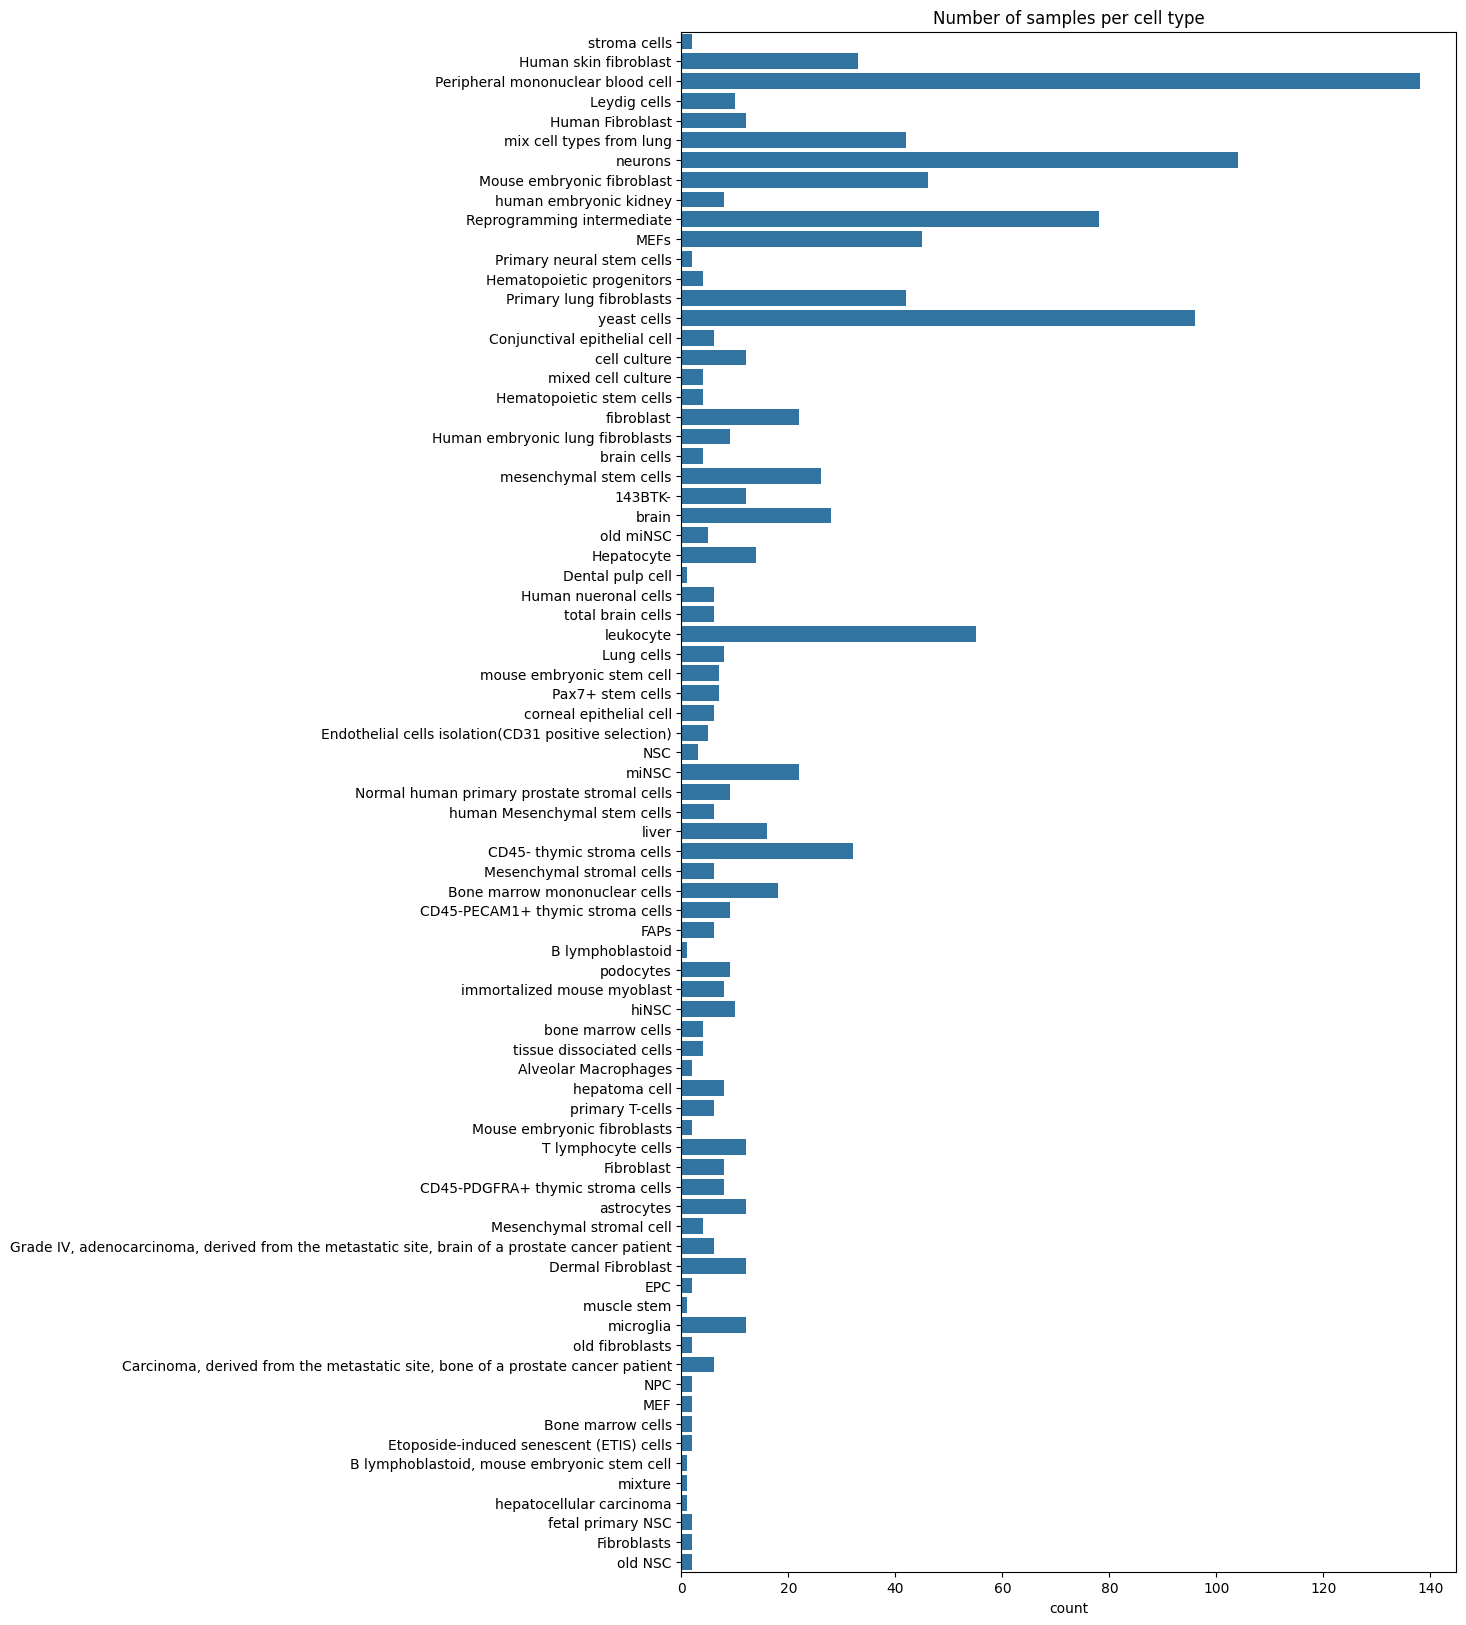

In [ ]:
cell_types = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(cell_types, ax=ax)
ax.set_title("Number of samples per cell type")

There are synonyms here as well.

As a side note, let's see if most samples contain either the tissue type or cell type as both are indicative of the tissue being studied. 

In [ ]:
contains_tissue_or_cell_type = [sample for sample in samples if "tissue" in sample.characteristics or "cell type" in sample.characteristics]
n_samples = len(samples)
n_contains = len(contains_tissue_or_cell_type)
print(f"{n_contains}/{n_samples} ({n_contains / n_samples * 100}%) contain tissue information")

3554/3946 (90.0658895083629%) contain tissue information


## Values of other characteristics fields

Time

In [ ]:
time_values = [sample.characteristics["time"] for sample in samples if "time" in sample.characteristics]
time_values += [sample.characteristics["time point"] for sample in samples if "time point" in sample.characteristics]
for time in set(time_values):
    print(time)


d0
isolation after 11 days of culture
isolation after 14 days of culture
isolation after 7 days of culture
isolation after 11 days after transfection
d0 (1st Day of adulthood)
7 hours
72 h
isolation after 21 days of culture


Age

In [ ]:
age_keys = set([key for key in characteristics_keys if "age" in key.split(" ")])
age_values = []
for age_key in age_keys:
    age_values += [sample.characteristics[age_key] for sample in samples if age_key in sample.characteristics]
print("Keys:", age_keys)
for age_value in set(age_values):
    print(age_value)

Keys: {'age', 'age (yr)', 'age (years)', 'age group'}
0.333333333
12 mounth
70
60
50 years
46
75
11.9 weeks
61 years
68
3-4 months old
70.4
30 years
55
75.1
45 years
83
59
42
24 months old
12.0 weeks
12 months
53
67
47 years old
86
6 weeks old
2 mounth
67 years old
37
71.8
28 years
65
74.5
69
2-3 months old
87
Day 1 of adulthood
0.666666667
26 years
9 Months
58 years
47 years
41
56 years
70.3
24-month-old
20-month old
22 month
72.3
44
67 years
42 years
24 months
82
80
89
75.7
36
84
31
48
24 Months
76.8
3 mo
21-22months old
69.3
older adults (>60 years old)
100
85
23 years
23
29 years
11.1 weeks
74 years old
49 years
99
110+
54 years
25 years
0-year-old
15 Months
24 mo
35
76.5
59 years
30 Months
40 years
2
Aged
15mo
60 years
24month
71.5
31 years
75.2
24-month
24 weeks
2.166666667
0.416666667
72.4
63 years
4 months
adult
32 years
28 months
21
11 months
27
97
39
Old
57
6-month
65 years
13 weeks
Young
62
75.5
73.2
73.7
27 years
Young Adult
02-month old
0.5
100-104
11 weeks
49
26 months
06

## Parsing age fields

Age is usually represented here as a number or range followed by a unit, or just a number.
However there are excpetions to this rule, for example ">60 years old", and they have to be handled differently.
There are also non-numerical descriptions such as Young, Middle and Old which cannot be converted into numbers.

In [ ]:
import re
INF_AGE = 999
MIN_AGE = 0


def normalize_to_years(value, unit):
    """Converts age to years based on the unit."""
    unit = unit.lower()
    if unit in ['year', 'years', 'yr', 'yrs', 'y']:
        return float(value)
    elif unit in ['month', 'months', 'mo', 'mos']:
        return float(value) / 12.0
    elif unit in ['week', 'weeks', 'wks', 'wk', 'w']:
        return float(value) / 52.0
    elif unit in ['day', 'days', 'd']:
        return float(value) / 365.0
    return None  # Should not happen if regex is correct


def extract_age(age_str: str):
    """
    Extratcts age in years or a range from a piece of text 
    stating the age or age group.
    If the age cannot be determined, the function returns null.

    :param age_str: Text from which to extract the age
    :returns: A single number containing the age or a pair if a range was detected.
    """
    age_str = str(age_str).lower().strip()  # Normalize text

    if is_number(age_str):
        return float(age_str)  # assume age is in years

    is_age_range, age_range = try_extract_age_range(age_str)
    if is_age_range:
        return age_range

    # Handle 110+
    is_age_plus, age_range = try_extract_age_plus(age_str)
    if is_age_plus:
        return age_range

    # Handle >60
    is_greater_than_age, age_range = try_extract_greater_than_age(age_str)
    if is_greater_than_age:
        return age_range
    
    # Handle <60
    is_less_than_age, age_range = try_extract_less_than_age(age_str)
    if is_less_than_age:
        return age_range

    is_age_plus_unit, age = try_extract_age_plus_unit(age_str)
    if is_age_plus_unit:
        return age

    
    return None


def try_extract_age_range(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*(year|yr|month|mo|week|wk|w|day|d)?s?\s*(old)?', age_str)
    if not match:
        return False, None
    val1 = float(match.group(1))
    val2 = float(match.group(2))
    unit = match.group(3)
    if unit:
        return True, (normalize_to_years(val1, unit), normalize_to_years(val2, unit))
    else:
        return True, (val1, val2)  # Assume years


def try_extract_age_plus_unit(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-?\s*(year|yr|month|mo|week|wk|w|day|d)s?\s*-?\s*(old)?', age_str)
    if not match:
        return False, None
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return True, normalize_to_years(value, unit)


def try_extract_age_plus(age_str: str):
    """
    Tries to extract ages like 110+ out of the text.
    """
    match = re.search(r'(\d+)\+', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_greater_than_age(age_str: str):
    """
    Tries to extract ages like >20 out of the text.
    """
    match = re.search(r'\>(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_less_than_age(age_str: str):
    """
    Tries to extract ages like <20 out of the text.
    """
    match = re.search(r'\<(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (MIN_AGE, float(match.group(1)))


def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

In [ ]:
for age in set(age_values):
    print(age, extract_age(age))

0.333333333 0.333333333
12 mounth 1.0
70 70.0
60 60.0
50 years 50.0
46 46.0
75 75.0
11.9 weeks 0.22884615384615387
61 years 61.0
68 68.0
3-4 months old (0.25, 0.3333333333333333)
70.4 70.4
30 years 30.0
55 55.0
75.1 75.1
45 years 45.0
83 83.0
59 59.0
42 42.0
24 months old 2.0
12.0 weeks 0.23076923076923078
12 months 1.0
53 53.0
67 67.0
47 years old 47.0
86 86.0
6 weeks old 0.11538461538461539
2 mounth 0.16666666666666666
67 years old 67.0
37 37.0
71.8 71.8
28 years 28.0
65 65.0
74.5 74.5
69 69.0
2-3 months old (0.16666666666666666, 0.25)
87 87.0
Day 1 of adulthood None
0.666666667 0.666666667
26 years 26.0
9 Months 0.75
58 years 58.0
47 years 47.0
41 41.0
56 years 56.0
70.3 70.3
24-month-old 2.0
20-month old 1.6666666666666667
22 month 1.8333333333333333
72.3 72.3
44 44.0
67 years 67.0
42 years 42.0
24 months 2.0
82 82.0
80 80.0
89 89.0
75.7 75.7
36 36.0
84 84.0
31 31.0
48 48.0
24 Months 2.0
76.8 76.8
3 mo 0.25
21-22months old (1.75, 1.8333333333333333)
69.3 69.3
older adults (>60 year

## Grouping tissues

In [ ]:
import scispacy.linking_utils

def create_without_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database.
    """
    nlp = spacy.load("en_core_sci_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp

def create_entity_linking_pipeline_with_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database
    that also performs named entity recognition.
    """
    nlp = spacy.load("en_ner_bionlp13cg_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp


def link_entities(nlp, document: str) -> List[scispacy.linking_utils.Entity]:
    """
    Links entities in the document to the knowledge base of the scicpacy pipeline 
    and returns the canonical names and match scores.

    :param nlp: Scispacy NLP pipeline for entity linking and named entity
    recognition (see create_entity_linking_pipeline).
    :param document: The document in which to link entities to UMLS.
    :returns: A list of tuples (entity, canonical_name, score, label) where:
        1. entity is the name of the entity as it appears in the text.
        2. canonical_name is the canonical name of the entity in the knowledge base.
        3. score is the score of the knowledge base match. 
        4. NER label of the entity (e.g. ORGANISM, CELL, ...) 
        If an entity does not exist in the knowledge base it will be returned as (entity, entity, -1, None).
    """
    processed_doc = nlp(document)
    linker = nlp.get_pipe("scispacy_linker")
    knowledge_base = linker.kb
    all_links = []
    for ent in processed_doc.ents:
        if not ent._.kb_ents:
            all_links.append((ent, ent, -1, ent.label_))
            continue

        concept_id, score = ent._.kb_ents[0]
        umls_entity = knowledge_base.cui_to_entity[concept_id]
        canonical_name = umls_entity.canonical_name
        entity_link = (ent, canonical_name, score, ent.label_)
        all_links.append(entity_link)
            
    return all_links

def get_canonical_name(nlp, tissue: str):
    entity_links = link_entities(nlp, tissue)
    if not entity_links:
        return (tissue, tissue, -1)

    relevant_labels = ["CELL", "TISSUE", "ORGAN", "PATHOLOGICAL_FORMATION"]
    relevant_links = list(filter(lambda link: link[3] in relevant_labels, entity_links))
    if relevant_links:
        return max(relevant_links, key=lambda link: link[2])[:3] # Return link with the highest score
    return max(entity_links, key=lambda link: link[2])[:3]


In [ ]:
nlp = create_entity_linking_pipeline_with_ner(knowledge_base="umls")

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


{"asctime": "2025-06-06 14:40:40,784", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-06 14:40:40,785", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-06 14:40:48,108", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-06 14:40:48,109", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-06 14:40:48,109", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-06 14:40:48,110", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-06 14:40:48,110", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-06 14:40:48,111", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:

unique_tissues = list(set(tissues))
 
entity_links_ner = [get_canonical_name(nlp, tissue) for tissue in unique_tissues]
for entity, canonical_name, score in entity_links_ner:
    print ("Entity:", entity)
    print ("Score:", score)
    print ("Cannonical name:", canonical_name)
    print("------")


Entity: Liver
Score: 0.9800863862037659
Cannonical name: Liver
------
Entity: testis
Score: 0.9958365559577942
Cannonical name: Testis
------
Entity: whole body of group-housed females at 21 dph
Score: -1
Cannonical name: whole body of group-housed females at 21 dph
------
Entity: testis
Score: 0.9958365559577942
Cannonical name: Testis
------
Entity: Skeletal muscle stem cells
Score: 0.8171794414520264
Cannonical name: Skeletal Myocytes
------
Entity: colon
Score: 0.9798353910446167
Cannonical name: Colon structure (body structure)
------
Entity: RPE/choroids
Score: 0.7280751466751099
Cannonical name: Choroid
------
Entity: ovary
Score: 0.9874809980392456
Cannonical name: Ovary
------
Entity: Brain cortex
Score: 0.7399120330810547
Cannonical name: brain subcortex
------
Entity: blood
Score: 0.9994040131568909
Cannonical name: Blood
------
Entity: skin
Score: 0.9756062626838684
Cannonical name: Skin Specimen
------
Entity: whole organism
Score: -1
Cannonical name: whole organism
------

### Scispacy vs LLM

In [ ]:
naming_df_dict = {
    "entity": unique_tissues,
    "scispacy_name": [link[1] for link in entity_links_ner],
    "llm_name": [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in unique_tissues]
}
naming_df = pd.DataFrame(naming_df_dict)
pd.set_option('display.max_rows', None)
naming_df

,entity,scispacy_name,llm_name
0,Liver,Liver,Liver
1,testis of single-housed males at 3 wph,Testis,testis of single-housed males at 3 wph
2,whole body of group-housed females at 21 dph,whole body of group-housed females at 21 dph,whole body of group-housed females at 21 dph
3,testis of group-housed males at 11 wph,Testis,testis of group-housed males at 11 wph
4,Skeletal muscle stem cells,Skeletal Myocytes,Skeletal muscle stem cells
5,colon,Colon structure (body structure),colon
6,RPE/choroids,Choroid,RPE/choroids
7,ovary of group-housed males at 5 wph,Ovary,ovary of group-housed males at 5 wph
8,Brain cortex,brain subcortex,Brain cortex
9,blood,Blood,blood


### NER vs no NER

In [ ]:
nlp_no_ner = create_without_ner()

{"asctime": "2025-06-06 14:41:41,649", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-06 14:41:41,651", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-06 14:41:48,399", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-06 14:41:48,400", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-06 14:41:48,401", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-06 14:41:48,401", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-06 14:41:48,401", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-06 14:41:48,402", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
entity_links_no_ner = [get_canonical_name(nlp_no_ner, tissue) for tissue in unique_tissues]
naming_df_dict = {
    "Entity": unique_tissues,
    "Name with NER": [link[1] for link in entity_links_ner],
    "Name without NER": [link[1] for link in entity_links_no_ner],
}
naming_df = pd.DataFrame(naming_df_dict)
pd.set_option('display.max_rows', None)
naming_df

,Entity,Name with NER,Name without NER
0,Liver,Liver,Liver
1,testis of single-housed males at 3 wph,Testis,Testis
2,whole body of group-housed females at 21 dph,whole body of group-housed females at 21 dph,phenytoin
3,testis of group-housed males at 11 wph,Testis,Testis
4,Skeletal muscle stem cells,Skeletal Myocytes,Stem cells
5,colon,Colon structure (body structure),colon
6,RPE/choroids,Choroid,Choroid
7,ovary of group-housed males at 5 wph,Ovary,Males
8,Brain cortex,brain subcortex,brain subcortex
9,blood,Blood,Blood


## Parsing cell types

In [ ]:
cell_types = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
unique_cell_types = list(set(cell_types))

In [ ]:
entity_links_cell_types = [get_canonical_name(nlp, cell_type) for cell_type in unique_cell_types]
naming_df_dict = {
    "Entity": unique_cell_types,
    "Name with NER": [link[1] for link in entity_links_cell_types],
}
naming_df = pd.DataFrame(naming_df_dict)
pd.set_option('display.max_rows', None)
naming_df

,Entity,Name with NER
0,Mouse embryonic fibroblast,Mouse Embryonic Fibroblast
1,neurons,neurons
2,Etoposide-induced senescent (ETIS) cells,Etoposide-induced senescent (ETIS) cells
3,Conjunctival epithelial cell,Conjunctival epithelial cell
4,hepatoma cell,hepatoma cell
5,B lymphoblastoid,B lymphoblast
6,T lymphocyte cells,T-Lymphocyte
7,human embryonic kidney,HEK293 Cells
8,tissue dissociated cells,Body tissue
9,"B lymphoblastoid, mouse embryonic stem cell",B lymphoblast


# Filtering datasets

## Retrieve by age range

In [ ]:


def do_ranges_overlap(range1: Tuple[float, float], range2: Tuple[float, float]) -> bool:
    return range1[0] <= range2[1] and range2[0] <= range1[1]


def is_sample_in_age_range(sample: GEOSample, age_range: Tuple[float, float]) -> bool:
    """
    Returns true if a sample's age falls into the age range (inclusive).

    :param sample: GEO sample whose age to check.
    :param age_range: Age range (from, to).
    :return: True if age is in range, false if it is not. If the
    sample does not have an age key, the function returns false.
    """
    age = sample.characteristics.get("age") or sample.characteristics.get(
        "age (yr)") or sample.characteristics.get("age (years)")
    if not age:
        return False
    age = extract_age(age)

    if isinstance(age, float):
        return age_range[0] < age < age_range[1]
    elif isinstance(age, Tuple):
        return do_ranges_overlap(age, age_range)
    elif age is None:
        return False # Cannot compare qualitative ages
    else:
        raise ValueError(f"Extracted age is of unexpected type: {type(age)}")


def dataset_has_sample_in_age_range(dataset: GEODataset, age_range: Tuple[float, float]) -> float:
    """
    Returns true if a dataset contains a sample whose age
    falls into the age range (inclusive).

    :param dataset: Dataset in which to check if it contains a sample
    of the desired age.
    :param age_range: Age range (from, to).
    :return: True if the sample contains a sample whose age is in the
    given age range, otherwise False.
    """
    return any(
        [is_sample_in_age_range(sample, age_range)
         for sample in dataset.samples]
    )


def filter_by_age_range(datasets: List[GEODataset], age_range: Tuple[float, float]):
    """
    Retrieves datasets that have samples whose age falls into the age range (inclusive).

    :param datasets: List of GEO Datasests/Series to search by age.
    :age_range: Tuple containing the age range to search for (from, to).
    :return: List of GEO datasets which contain samples that fall into the
    desired age range.
    """
    return list(filter(lambda d: dataset_has_sample_in_age_range(d, age_range), datasets))

In [ ]:
for d in filter_by_age_range(datasets, (18, 30)):
    print(d.id)


GSE275442
GSE242202
GSE235717
GSE226636
GSE212109
GSE202601
GSE201118
GSE182786


## Filter by presence of characteristic

In [ ]:
def filter_by_has_characteristic(datasets: List[GEODataset], characteristic: List[str]):
    """
    Retrieves datasets that contain a sample that for which the given characteristic
    is specified.

    :param datasets: List of datasets to filter.
    :param characteristic: The characteristic the samples must have.
    :return: List of datasets which contain a sample that has the specified charcteristic.
    """
    return list(filter(
        lambda dataset: any(
            [characteristic in sample.characteristics for sample in dataset.samples]
        ),
        datasets
    ))

Let's see which datasets have sarcopenia status specified.

In [ ]:
sarcopenia_datasets = filter_by_has_characteristic(datasets, "sarcopenia status")
for dataset in sarcopenia_datasets:
    print(dataset.id)
    print(dataset)

GSE111017
Study of sarcopenia in human muscle biopsies of elderly individuals
Expression profiling by high throughput sequencing
Homo sapiens
GSE111016
Study of sarcopenia in human muscle biopsies of elderly individuals, Singapore Sarcopenia Study
Expression profiling by high throughput sequencing
Purpose: The main goal of this study is to compare skeletal muscle transcriptome profilings derived from sarcopenic versus healthy subjects.
Homo sapiens
20 muscle biopsies from healthy subjects and 20 muscle biopsies from sarcopenic subjects.


Next, we will check out the composition of the samples.

In [ ]:
def extract_characteristic_values(samples: List[GEOSample], characteristic: str):
    return[sample.characteristics[characteristic] for sample in samples if characteristic in sample.characteristics]


In [ ]:
sarcopenia_samples = [sample for dataset in sarcopenia_datasets for sample in dataset.samples]
sarcopenia_samples = list(set(sarcopenia_samples)) # We need to remove duplicates because the first dataset is a superseries containing the second series
sarcopenia_statuses = extract_characteristic_values(sarcopenia_samples, "sarcopenia status")
sarcopenia_sample_sexes = extract_characteristic_values(sarcopenia_samples, "Sex")
sarcopenia_statuses = pd.Series(sarcopenia_statuses)
sarcopenia_sample_sexes = pd.Series(sarcopenia_sample_sexes)
print ("Sarcopenia status of the samples in the sarcopenia study")
print(sarcopenia_statuses.value_counts())
print ("Sexes of the samples in the sarcopenia study")
print(sarcopenia_sample_sexes.value_counts())

Sarcopenia status of the samples in the sarcopenia study
no     86
yes    33
Name: count, dtype: int64
Sexes of the samples in the sarcopenia study
male    119
Name: count, dtype: int64


## Filter by publication date

In [ ]:
def filter_by_publication_date(datasets: List, date_range: Tuple[datetime.datetime, datetime.datetime]):
    return filter(lambda d: date_range[0] <= d.publication_date <= date_range[1], datasets)

NameError: name 'List' is not defined

In [ ]:
for dataset in filter_by_publication_date(datasets, (datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))):
    print(dataset.id)
    print(dataset)

NameError: name 'filter_by_publication_date' is not defined